In [1]:
%%capture
!pip install shapely
!pip install geopandas
!pip install folium
!pip install config
!pip install timezonefinder
#viz packages
!pip install descartes 
!pip install mapclassify 
!pip install contextily==1.0rc2


In [2]:
#Function to get isolines  
from shapely.geometry import Polygon,  Point
from shapely import wkt
import requests
import json
import geopandas as gpd
from geopandas import GeoSeries
import folium
import config
import pandas as pd
import numpy as np

import timezonefinder as tf
from timezonefinder import TimezoneFinder
tf = TimezoneFinder()
from datetime import datetime, timezone, date, time, timedelta

# viz
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline
import contextily as ctx
import mapclassify
import descartes

In [4]:
# Get LatLon from address
def get_latlon(event_address):
    get_latlon = f'https://geocoder.ls.hereapi.com/6.2/geocode.json?searchtext={event_address}&gen=9&apiKey=CvCsf7byXWXESq3FtlGpWXUWRqYEnj-W8k9amDXCJJ4'
    js_latlon = requests.get(url = get_latlon).json()['Response']['View'][0]['Result'][0]['Location']['DisplayPosition']
    return js_latlon

# Get UTC Timezone offset based on LatLon
def get_offset(*, Latitude, Longitude):
    from datetime import datetime
    from pytz import timezone, utc
    today = datetime.now()
    tz_target = timezone(tf.certain_timezone_at(lng=Longitude, lat=Latitude))
    today_target = tz_target.localize(today)
    today_utc = utc.localize(today)
    return(int((today_utc - today_target).total_seconds() / 3600))

# Convert Arrival Time to ISO format
def get_isotime(start_time, event_date, utc_offset):
    t_24 = datetime.strptime(start_time,'%I:%M%p')
    d = datetime.strptime(event_date,'%Y-%m-%d')
    dt_24 = datetime.combine(d.date(),t_24.timetz(),tzinfo=timezone(timedelta(hours=utc_offset)))
    arrival_time = dt_24.isoformat(sep='T')
    return arrival_time

# Get Isoline from HERE API
def get_isodata(lat,lon,
                trip_mode,
                trip_duration,
                arrival_time,
                meters_per_pixel):   
    try: 
        obtain_isoline = (f'https://isoline.route.ls.hereapi.com/routing/7.2/calculateisoline.json' +
        f'?apiKey=CvCsf7byXWXESq3FtlGpWXUWRqYEnj-W8k9amDXCJJ4'+
        f'&mode=fastest;{trip_mode}'+
        f'&destination=geo!{lat},{lon}'+
        f'&range={trip_duration}'+
        f'&rangetype=time'+
        f'&resolution={meters_per_pixel}'+
        f'&singlecomponent=true'+
        f'&arrival={arrival_time}')
        js_isoline = requests.get(url = obtain_isoline).json()['response']['isoline'][0]['component'][0]['shape']
        coords = Polygon([(float(x.split(',')[1]), float(x.split(',')[0])) for x in js_isoline])
        geojs = gpd.GeoSeries([coords])
        geojs.crs = {'init' : 'epsg:4326'}
        return geojs
    except KeyError:
        js = requests.get(url).json()
        print(js)
        raise ValueError("HereAPI doesn't have data requested")
    except IndexError:
        print(js)
        raise ValueError("HereAPI doesn't have quality data")
        

In [5]:
# User input event details
# Format {event_id: ['Address City State ZIP', '9:00AM', 'YYYY-MM-DD', 'car', Max travel time (minutes), 'Name of event'],
#         event_id: ['Address City State ZIP', '3:00PM', 'YYYY-MM-DD', 'pedestrian', Max travel time (minutes), 'Name of event']}
EVENT_DICT = {181311:['102 Chamber Dr Anamosa, IA 52205','11:00AM','2020-01-03','car',60,'anamosa'],
              181312:['1712 W 4th St Waterloo, IA 50701','2:00PM','2020-01-03','car',60,'waterloo'],
              181316:['900 E Main St, Decorah, IA 52101','5:00PM','2020-01-03','car',60,'decorah'],
              181318:['1800 Clarke Dr Dubuque, IA 52001','11:00AM','2020-01-04','car',60,'dubuque'],
              181319:['705 F Ave Grundy Center, IA 50638','2:30PM','2020-01-04','car',60,'grundy'],
              181321:['308 S Pennsylvania Ave, Mason City, IA 50401','5:00PM','2020-01-04','car',60,'mason'],
              181323:['1900 Lakewood Dr Boone, IA 50036','10:00AM','2020-01-05','car',60,'boone']
             }

# Output table
OUTPUT_TABLE = 'bernie_nmarchio2.isoline_test'

# Min travel range in seconds (and increment of isoline series)
min_range = 300 # 5 minutes
time_increment = 300 # 5 minutes
isoline_resolution = 100 # meters per pixel, recommended 100 for 'car' and 10 for 'pedestrian'


In [7]:
# Get isolines geometries and create table
event_object = []
event_gpd = gpd.GeoDataFrame()
for i in EVENT_DICT.items():
    event_coords = get_latlon(event_address=i[1][0].replace(' ','%20'))
    hour_offset = get_offset(**event_coords)
    timestamp = get_isotime(start_time=str(i[1][1]),
                            event_date=str(i[1][2]),
                            utc_offset=hour_offset)
    commute_mode = i[1][3]
    max_range = int(i[1][4])*60
    for commute_time in range(min_range, max_range, time_increment):
        if (commute_mode == 'pedestrian' and commute_time <= 1800) or commute_mode == 'car':
            isoline = get_isodata(lat=event_coords['Latitude'],
                                  lon=event_coords['Longitude'],
                                  trip_mode=commute_mode,
                                  trip_duration=commute_time,
                                  arrival_time=timestamp,
                                  meters_per_pixel=isoline_resolution)
            iso_bbox = isoline.envelope
            search_geom = gpd.GeoDataFrame(geometry = iso_bbox)['geometry'].geometry
            search_array = [i for i in search_geom.geometry]
            x,y = search_array[0].exterior.coords.xy
            df = pd.DataFrame({'event_input':[i],
                               'event_id':[i[0]],
                               'event_address':[i[1][0]],
                               'event_latlon':[event_coords],
                               'event_time':[timestamp],
                               'trip_mode': [commute_mode],
                               'trip_duration_minutes': [commute_time/60],
                               'search_max_lat':[max(y)],
                               'search_min_lat':[min(y)],
                               'search_max_lon':[max(x)],
                               'search_min_lon':[min(x)]
                              })
            isoline_gdf = gpd.GeoDataFrame(df, geometry = isoline)
            isoline_gdf.crs = {'init':'epsg:4326'}
            event_gpd = pd.concat([event_gpd, isoline_gdf])


In [8]:
event_gpd.head(n=5)

event_input  event_id  \
0  (181311, [102 Chamber Dr Anamosa, IA 52205, 11...    181311   
0  (181311, [102 Chamber Dr Anamosa, IA 52205, 11...    181311   
0  (181311, [102 Chamber Dr Anamosa, IA 52205, 11...    181311   
0  (181311, [102 Chamber Dr Anamosa, IA 52205, 11...    181311   
0  (181311, [102 Chamber Dr Anamosa, IA 52205, 11...    181311   

                      event_address  \
0  102 Chamber Dr Anamosa, IA 52205   
0  102 Chamber Dr Anamosa, IA 52205   
0  102 Chamber Dr Anamosa, IA 52205   
0  102 Chamber Dr Anamosa, IA 52205   
0  102 Chamber Dr Anamosa, IA 52205   

                                     event_latlon                 event_time  \
0  {'Latitude': 42.10527, 'Longitude': -91.26578}  2020-01-03T11:00:00-06:00   
0  {'Latitude': 42.10527, 'Longitude': -91.26578}  2020-01-03T11:00:00-06:00   
0  {'Latitude': 42.10527, 'Longitude': -91.26578}  2020-01-03T11:00:00-06:00   
0  {'Latitude': 42.10527, 'Longitude': -91.26578}  2020-01-03T11:00:00-06:00   
0  {'Latitude': 42.10527, 'Longitude': -91.26578}  2020-01-03T11:00:00-06:00   

  trip_mode  trip_duration_minutes  search_max_lat  search_min_lat  \
0       car                    5.0       42.145615       42.056351   
0       car                   10.0       42.206726       41.998672   
0       car                   15.0       42.264404       41.934815   
0       car                   20.0       42.291870       41.896362   
0       car                   25.0       42.335815       41.857910   

   search_max_lon  search_min_lon  \
0      -91.228409      -91.315269   
0      -91.135025      -91.408997   
0      -91.051941      -91.507530   
0      -90.995636      -91.554565   
0      -90.922852      -91.625977   

                                            geometry  
0  POLYGON ((-91.31252 42.07214, -91.29913 42.072...  
0  POLYGON ((-91.40591 42.06390, -91.40350 42.063...  
0  POLYGON ((-91.50478 42.04742, -91.49689 42.047...  
0  POLYGON ((-91.54976 42.04056, -91.54907 42.044...  
0  POLYGON ((-91.61980 42.02820, -91.61636 42.026...

<Figure size 1800x1200 with 0 Axes>

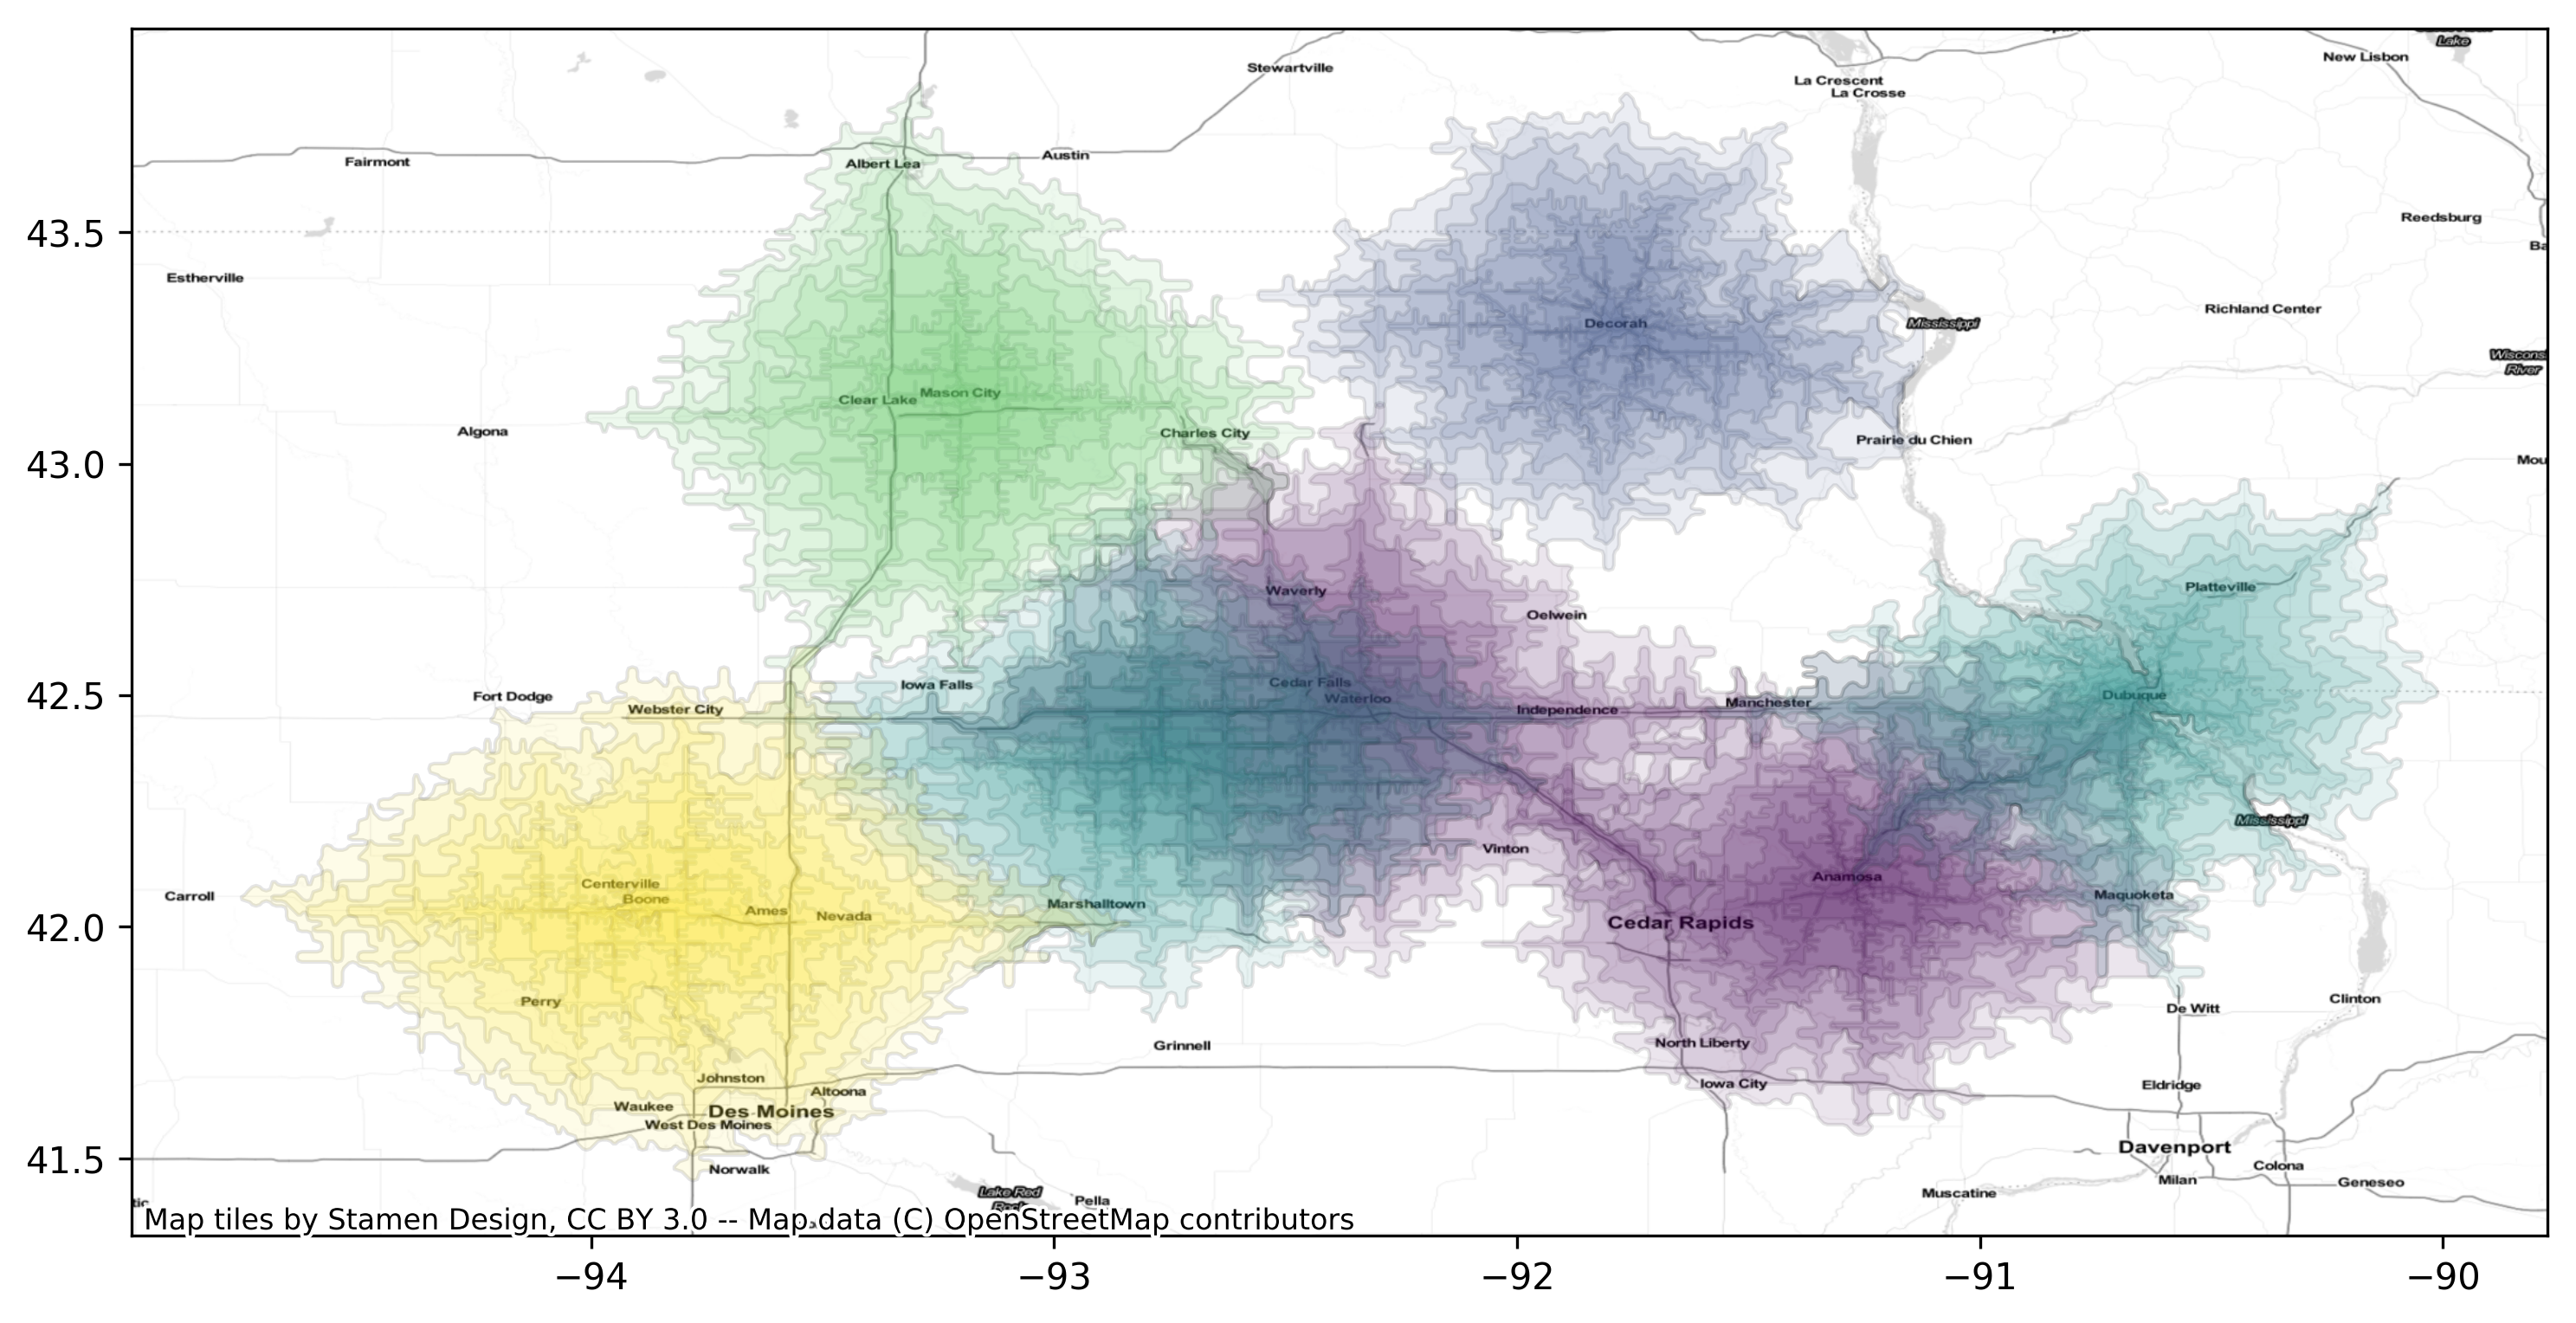

In [9]:
# Visualize isolines
plt.rcParams['figure.dpi'] = 300
plt.set_cmap('viridis')
iso_viz = event_gpd.plot(column = 'event_id', 
                         scheme='quantiles', 
                         alpha=.1, 
                         figsize=(12, 10), edgecolor='k')

ctx.add_basemap(iso_viz, crs= event_gpd.crs,  url=ctx.providers.Stamen.TonerLite) 

In [10]:
# Upload isoline geometries table to platform
create_geojson_df = civis.io.dataframe_to_civis(df=event_gpd,
                                                database='Bernie 2020', 
                                                table= f'{OUTPUT_TABLE}_geometries', 
                                                existing_table_rows='drop')
create_geojson_df.result()

{'created_at': '2020-01-02T18:00:31.000Z',
 'error': None,
 'finished_at': '2020-01-02T18:00:41.000Z',
 'id': 196553393,
 'started_at': '2020-01-02T18:00:31.000Z',
 'state': 'succeeded'}

In [11]:
# Assemble where SQL for voterfile and event isoline table
search_area_list = []
for i in event_gpd['event_id'].unique():
    max_of_search_max_lat = event_gpd[(event_gpd["event_id"] == i)]['search_max_lat'].max()
    min_of_search_min_lat = event_gpd[(event_gpd["event_id"] == i)]['search_min_lat'].min()
    max_of_search_max_lon = event_gpd[(event_gpd["event_id"] == i)]['search_max_lon'].max()
    min_of_search_min_lon = event_gpd[(event_gpd["event_id"] == i)]['search_min_lon'].min()
    where_sql_search_area = f''' where (v_latitude >= {min_of_search_min_lat} AND v_latitude <= {max_of_search_max_lat}) AND (v_longitude >= {min_of_search_min_lon} AND v_longitude <= {max_of_search_max_lon})'''
    search_area = {'event_id':i,
                   'where_sql':where_sql_search_area}
    search_area_list.append(search_area)
    

In [12]:
# Assemble full SQL query to intersect voterfile with isolines
isoline_base_sql = []
for i in range(len(search_area_list)):
    where_sql_event = search_area_list[i]['event_id']
    where_sql_person = search_area_list[i]['where_sql']
    base_query =  base_query = f'''-- Query for event_id = {where_sql_event}
    (select * from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, row_number() over (partition by person_id order by trip_duration_minutes asc) as travel_rank from (select person_id, event_id, event_input, trip_mode, min(trip_duration_minutes) as trip_duration_minutes from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, ST_Within(voter,event) from 
    (select person_id, ST_SetSRID(ST_MakePoint(v_longitude, v_latitude),4326) as voter from bernie_data_commons.rainbow_analytics_frame {where_sql_person}) a, 
    (select event_id, event_input, trip_mode, trip_duration_minutes, ST_GeomFromText(geometry,4326) as event from (select * from {OUTPUT_TABLE}_geometries where event_id = {where_sql_event} )) b) 
    where st_within is true group by 1,2,3,4)) where travel_rank = 1) '''
    isoline_base_sql.append(base_query)
    
isoline_calculation_sql = "\nunion all\n".join([" {query} ".format(query=q) for q in isoline_base_sql])

In [16]:
create_output_table = f"""
set query_group to 'importers';
set wlm_query_slot_count to 3;
DROP TABLE IF EXISTS {OUTPUT_TABLE};
CREATE TABLE {OUTPUT_TABLE}
  DISTKEY (person_id) 
  AS (select * from 
  (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, 
  row_number() over (partition by person_id order by trip_duration_minutes asc) as overall_rank from 
  ({isoline_calculation_sql})
  ) where overall_rank = 1);"""

In [17]:
print(create_output_table)


set query_group to 'importers';
set wlm_query_slot_count to 3;
DROP TABLE IF EXISTS bernie_nmarchio2.isoline_test;
CREATE TABLE bernie_nmarchio2.isoline_test
  DISTKEY (person_id) 
  AS (select * from 
  (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, 
  row_number() over (partition by person_id order by trip_duration_minutes asc) as overall_rank from 
   -- Query for event_id = 181311
    (select * from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, row_number() over (partition by person_id order by trip_duration_minutes asc) as travel_rank from (select person_id, event_id, event_input, trip_mode, min(trip_duration_minutes) as trip_duration_minutes from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, ST_Within(voter,event) from 
    (select person_id, ST_SetSRID(ST_MakePoint(v_longitude, v_latitude),4326) as voter from bernie_data_commons.rainbow_analytics_frame  where (v_latitude >= 41.550293 AND v_

In [18]:
output_table = civis.io.query_civis(sql=create_output_table, database='Bernie 2020')
output_table.result()


{'author': {'id': 8505,
  'initials': 'NM',
  'name': 'Nicholas Marchio',
  'online': False,
  'username': 'nmarchio2'},
 'created_at': '2020-01-02T18:06:32.000Z',
 'credential': 15433,
 'database': 1392,
 'error': None,
 'exception': None,
 'finished_at': '2020-01-02T18:21:34.000Z',
 'hidden': True,
 'id': 55084693,
 'last_run_id': 196555135,
 'name': 'Query #55084693',
 'report_id': None,
 'result_columns': [],
 'result_rows': [],
 'script_id': None,
 'sql': "\nset query_group to 'importers';\nset wlm_query_slot_count to 3;\nDROP TABLE IF EXISTS bernie_nmarchio2.isoline_test;\nCREATE TABLE bernie_nmarchio2.isoline_test\n  DISTKEY (person_id) \n  AS (select * from \n  (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, \n  row_number() over (partition by person_id order by trip_duration_minutes asc) as overall_rank from \n   -- Query for event_id = 181311\n    (select * from (select person_id, event_id, event_input, trip_mode, trip_duration_minutes, row_number(

In [19]:
# Check out counts for each event
summary_df = f'select event_input, count(*) from {OUTPUT_TABLE} where trip_duration_minutes <= 45 group by 1 order by 2 desc;'
summary_table = civis.io.read_civis_sql(sql=summary_df , database='Bernie 2020', use_pandas=True)
pd.set_option('display.max_colwidth', -1)
display(summary_table)

event_input  \
0  (181323, ['1900 Lakewood Dr Boone, IA 50036', '10:00AM', '2020-01-05', 'car', 60, 'boone'])              
1  (181311, ['102 Chamber Dr Anamosa, IA 52205', '11:00AM', '2020-01-03', 'car', 60, 'anamosa'])            
2  (181312, ['1712 W 4th St Waterloo, IA 50701', '2:00PM', '2020-01-03', 'car', 60, 'waterloo'])            
3  (181319, ['705 F Ave Grundy Center, IA 50638', '2:30PM', '2020-01-04', 'car', 60, 'grundy'])             
4  (181318, ['1800 Clarke Dr Dubuque, IA 52001', '11:00AM', '2020-01-04', 'car', 60, 'dubuque'])            
5  (181321, ['308 S Pennsylvania Ave, Mason City, IA 50401', '5:00PM', '2020-01-04', 'car', 60, 'mason'])   
6  (181316, ['900 E Main St, Decorah, IA 52101', '5:00PM', '2020-01-03', 'car', 60, 'decorah'])             

    count  
0  258175  
1  207906  
2  144988  
3  139315  
4  83444   
5  70728   
6  37039

In [20]:
# Distribution of travel times around the events
qc_df = f'''select person_id, event_input, trip_mode, trip_duration_minutes, v_latitude, v_longitude, geometry
from {OUTPUT_TABLE} left join (select person_id, v_latitude, v_longitude, ST_AsText(ST_SetSRID(ST_MakePoint(v_longitude, v_latitude),4326)) as geometry from bernie_data_commons.rainbow_analytics_frame) using(person_id)
where trip_duration_minutes <= 45 order by random() limit 100000'''

qc_table = civis.io.read_civis_sql(sql=qc_df, database='Bernie 2020', use_pandas=True)


In [21]:
qc_table.head(n=5)

person_id  \
0  375655656   
1  169948742   
2  276567472   
3  192502154   
4  179650583   

                                                                                     event_input  \
0  (181319, ['705 F Ave Grundy Center, IA 50638', '2:30PM', '2020-01-04', 'car', 60, 'grundy'])    
1  (181311, ['102 Chamber Dr Anamosa, IA 52205', '11:00AM', '2020-01-03', 'car', 60, 'anamosa'])   
2  (181323, ['1900 Lakewood Dr Boone, IA 50036', '10:00AM', '2020-01-05', 'car', 60, 'boone'])     
3  (181311, ['102 Chamber Dr Anamosa, IA 52205', '11:00AM', '2020-01-03', 'car', 60, 'anamosa'])   
4  (181311, ['102 Chamber Dr Anamosa, IA 52205', '11:00AM', '2020-01-03', 'car', 60, 'anamosa'])   

  trip_mode  trip_duration_minutes  v_latitude  v_longitude  \
0  car       40                     42.473526  -92.266930     
1  car       35                     42.078842  -91.677452     
2  car       10                     42.053413  -93.874710     
3  car       40                     42.049709  -91.781761     
4  car       40                     41.850891  -91.655762     

                                    geometry  
0  POINT(-92.2669296264648 42.4735260009766)  
1  POINT(-91.6774520874023 42.0788421630859)  
2  POINT(-93.8747100830078 42.0534133911133)  
3  POINT(-91.7817611694336 42.0497093200684)  
4  POINT(-91.65576171875 41.8508911132812)

No handles with labels found to put in legend.


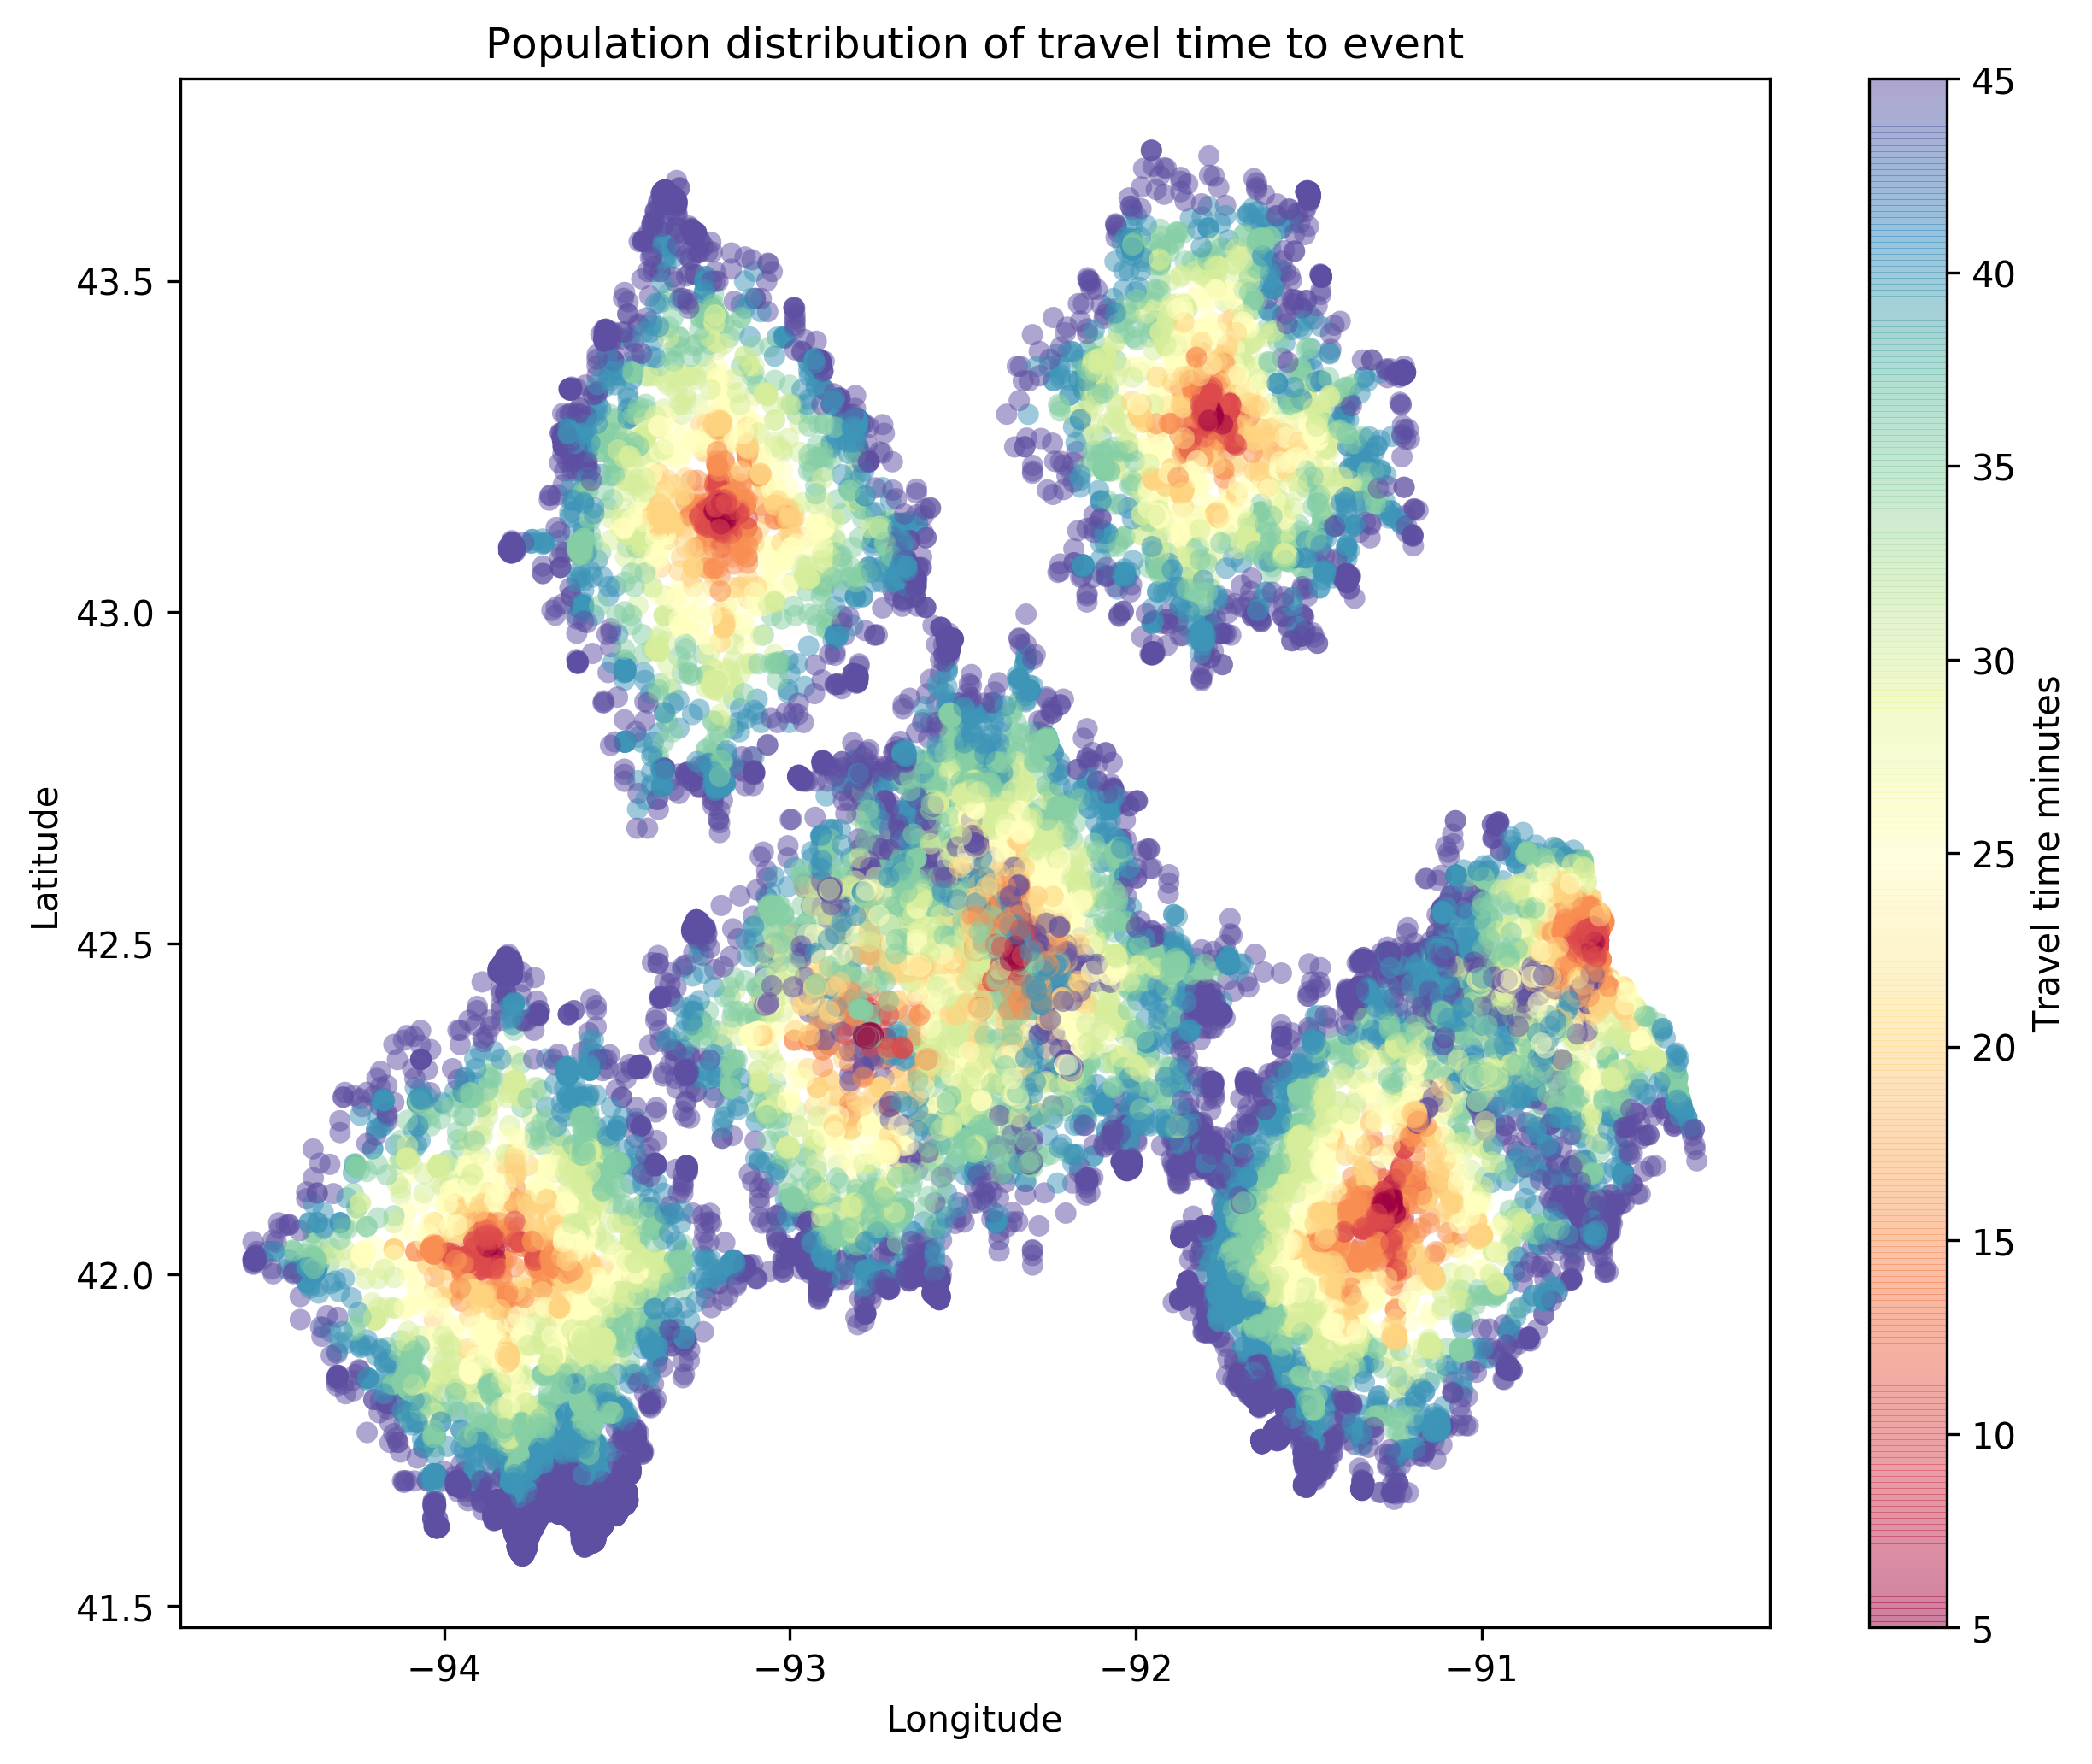

In [22]:
# Visualize travel time to events
lat, lon = qc_table['v_latitude'], qc_table['v_longitude']
minutes = qc_table['trip_duration_minutes']

plt.figure(figsize=(10,8), dpi=300)
plt.scatter(lon, lat, label = None,
            c=minutes, cmap='Spectral',marker = "o",  
            linewidth=0, alpha=0.5)
plt.axis(aspect='equal')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Travel time minutes')
plt.clim(5, 45)

plt.legend(scatterpoints=1, frameon=False, labelspacing=1)#, title='City Area'

plt.title('Population distribution of travel time to event');
